### Gino's playground

In [28]:
# IMPORTS
import datadotworld as dw
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys; sys.path.append("./libraries/")
from utils import *

#### Settings

In [29]:
# Relative Paths
RAW_DATA = "../data/raw/"
PROC_DATA = "../data/processed/"

# Flags
process = False

In [40]:
# If process, load raw data and apply matching between datasets 
# NOTE: It may take several minutes
if process:
    # Raw player's datasets
    players = pd.read_csv('https://query.data.world/s/gksm6hx4xzgjaed7tia2uzpafwvyjo?dws=00000')
    ratings22 = pd.read_csv(RAW_DATA + "FIFA22_player_ratings.csv") # FIFA player attributes from 2022
    ratings21 = pd.read_csv(RAW_DATA + "FIFA21_player_ratings.csv") # FIFA player attributes from 2022
    # This appends players from 2021 not present in 2022
    extended = set(ratings21.sofifa_id).difference(set(ratings22.sofifa_id))
    FIFA = pd.concat([ratings22, ratings21[ratings21.sofifa_id.isin(extended)]]).reset_index()

    # Remove uninformative columns
    players.drop(["player_code", "agent_name", "image_url", "url"], axis=1, inplace=True)
    FIFA.drop(["player_url", "club_team_id", "club_position", "club_jersey_number", "club_loaned_from", "club_joined", 
                "nationality_id", "nation_team_id", "nation_jersey_number", "real_face", "player_tags", "player_face_url", 
                "club_logo_url", "club_flag_url", "nation_logo_url", "nation_flag_url"], axis=1, inplace=True)
    
    # Find matches using custom function
    longname_matches = match_players(players, ratings)
    # Append the extracted FIFA long names
    players["FIFA_long_name"] = longname_matches

    ## Merge players with FIFA attributes
    # Create a unique identifier with long name and year of birth
    players["fifa_id"] = players["FIFA_long_name"] + "-" + pd.to_datetime(players["date_of_birth"]).dt.year.astype(str)
    FIFA["fifa_id"] = FIFA.long_name + "-" + pd.to_datetime(FIFA["dob"]).dt.year.astype(str)
    # Join
    players = players.merge(FIFA, on="fifa_id", how="inner")
    # Drop temp id cols
    players.drop(["name", "fifa_id", "sofifa_id"], axis=1, inplace=True)
    # Save dataset
    players.to_csv(PROC_DATA + "players_wFIFAattributes.csv", index=False)

# Else load processed data
else:
    players = pd.read_csv(PROC_DATA + "players_wFIFAattributes.csv")

# Get valuation data
valuations = pd.read_csv('https://query.data.world/s/y4qg2twfvou4w2ghz6o3evju32g7yn?dws=00000') 
# ... (we can get some more datasets if needed)

In [41]:
print(players.info())
players.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11159 entries, 0 to 11158
Columns: 112 entries, player_id to gk
dtypes: float64(15), int64(44), object(53)
memory usage: 9.5+ MB
None


,player_id,first_name,last_name,FIFA_long_name,last_season,country_of_birth,city_of_birth,country_of_citizenship,date_of_birth,sub_position,...,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk
0,3875,Jermain,Defoe,Jermain Colin Defoe,2021,England,London,England,1982-10-07,Centre-Forward,...,43+2,43+2,43+2,43+2,40+2,38+2,38+2,38+2,40+2,18+2
1,4742,Christophe,Lepoint,Christophe Lepoint,2022,Belgium,Brussel,Belgium,1984-10-24,Central Midfield,...,68-1,68-1,68-1,62+2,62+2,67,67,67,62+2,16+2
2,6838,Henok,Goitom,Henok Goitom,2015,Sweden,Solna,Eritrea,1984-09-22,Centre-Forward,...,55+2,55+2,55+2,50+2,48+2,50+2,50+2,50+2,48+2,17+2
3,10003,Wes,Morgan,Wes Morgan,2020,England,Nottingham,Jamaica,1984-01-21,Centre-Back,...,64+2,64+2,64+2,54+2,57+2,73,73,73,57+2,16+2
4,10471,NaN,Luiz Gustavo,Luiz Gustavo Dias,2021,Brazil,Pindamonhangaba,Brazil,1987-07-23,Defensive Midfield,...,75+2,75+2,75+2,71+3,71+3,75+2,75+2,75+2,71+3,17+3


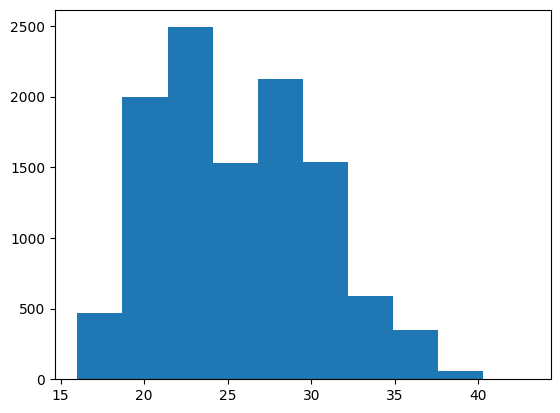

In [43]:
fig, ax = plt.subplots()

ax.hist(players.age);

In [8]:
# Detect retired:
## Conditions:
### Last season < 2021
### No current club (NAN)
### No Market value in EUR (NAN)
### No Contract Expiration date (NAN)
players.loc[(players.last_season < 2021) & (players.current_club_name.isna()) & (players.market_value_in_eur.isna()) & (players.contract_expiration_date.isna()), "age"].hist();

In [9]:
players.loc[(players.last_season < 2021) & (players.current_club_name.isna()) & (players.market_value_in_eur.isna()) & (players.contract_expiration_date.isna()), "age"].count()

3942

In [10]:
players.loc[6739]

player_id                                       844356
first_name                                       Petro
last_name                                     Velychko
name                                    Petro Velychko
FIFA_long_name                                     NaN
last_season                                       2020
country_of_birth                                   NaN
city_of_birth                                      NaN
country_of_citizenship                         Ukraine
date_of_birth                               2004-08-28
sub_position                               Centre-Back
position                                      Defender
foot                                             right
height_in_cm                                     190.0
market_value_in_eur                                NaN
highest_market_value_in_eur                        NaN
contract_expiration_date                           NaN
current_club_domestic_competition_id              UKR1
current_cl